In [10]:
import codecs
import json
import time

import matplotlib.pyplot as plt
import numpy as np
from eli5.lime import TextExplainer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC

### Chargement du dataset

Fonction permettant l'ouverture d'un jeu de ticket sauvegardé au format json.

In [11]:
def load_dataset(json_path):
    raw_data = []
    with codecs.open(json_path, "r", "utf-8") as fin:
        raw_data += json.load(fin)
    return raw_data

### Fonction de multiplication des titres des tickets

Multiplication du titre des tickets par le facteur donné en paramètre. 

In [12]:
def multiply_title(dataset, factor):
    for ticket in dataset:
        for i in range(1,factor):
            ticket["title"] += " " + ticket["title"]

### Fonction de binarisation des labels

Permet de convertir les labels "NBUG" et "BUG" en une information binaire 0 ou 1
* 0 = NBUG
* 1 = BUG

In [13]:
def binarization_labels(labels):
    return np.ravel(label_binarize(labels, classes=["NBUG","BUG"]))

### Fonction de récupération du corpus et des étiquettes

Cette fonction retourne deux tableaux :
* Le premier est un tableau contenant les informations textuelles des tickets (pour chaque ticket, le title est concaténé au body)
* Le second tableau contient les labels textuelles associées à chacun des tickets.

In [14]:
def get_corpus_labels(raw_data):
# Corpus building.
    corpus = []
    labels = []
    n_bug = 0
    for n_file in raw_data:
        corpus.append(n_file["title"] + " " + n_file["body"])
        labels.append(n_file["label"])
        if n_file["label"] == "BUG":
            n_bug += 1
    print(f"{n_bug} BUG / {len(labels)} \n")
    return corpus, labels

### Fonction d'évaluation d'un classifieur avec un train/test split

Cette fonction permet l'évaluation d'un classifieur sur la base d'une division du jeu de données en 2 parties :
* une partie dédiée à l'entraînement (partie dite _train_)
* une partie dédiée au test du classifieur (partie dite _test_)
Ici 77% des données du dataset sont destinées à l'entraînement et 33% au test du classifieur. 
La fonction calcule les mesures F1, rappel et précision. Elle dispose de 4 paramètres :
* X : le corpus complet vectorisé
* binarized_labels : la liste des labels binarisés
* clf : le classifieur à évaluer

In [15]:
def make_scoring_train_test_split(X,binarized_labels, clf, test_size=33):
    X_train, X_test, y_train, y_test = train_test_split(X, binarized_labels, test_size=test_size, random_state=42)

    start_time = time.time()
    #scores = cross_val_score(clf, X, binarized_labels, cv=cv, scoring='f1')
    print("--- Start training ---",flush=True)
    clf.fit(X_train, y_train)
    print("--- %s seconds for training ---" % (time.time() - start_time),flush=True)
    y_pred = clf.predict(X_test)

    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)

    print("F1 score train/test: %0.3f" % f1)
    print("Recall score train/test: %0.3f" % recall)
    print("Precision score train/test: %0.3f" % precision)
    print()

### Fonction de vectorisation et de calcul des features les plus représentatives
Cette fonction prend 4 paramètres en entrée : 
* corpus : tableau d'éléments textuels extraits avec la fonction <code>get_corpus_labels</code>
* labels : tableau de labels binarisés avec la fonction <code>binarization_labels</code>
* vectorizer : objet vectorizer pour transformer le corpus 
* k_best : nombre de features représentatives du corpus à sélectionner à l'aide du chi-deux
* print_feature_names : afficher ou non les features sélectionnées par le chi2


Vous allez devoir compléter la fonction <code>feature_computing</code>, pour cela :
1. Utilisez le vectorizer passé en paramètre afin de transformer les informations textuelles en informatiques mathématiques (vecteurs) utilisables par des classifieurs. Ces vecteurs sont créés à l'aide de la méthode _Term Frequency-Inverse Document Frequency_ ([wiki TF-IDF](https://fr.wikipedia.org/wiki/TF-IDF)) Pour cela référez vous à la fonction <code>fit_transform</code> ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidf#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform)). Vous affecterez le retour de <code>fit_transform</code> à une variable nommée <code>X</code>. 
2. La seconde étape consiste à sélectionner les features les plus représentatives du corpus. Un moyen de faire cela est d'utiliser la méthode du Chi-deux. La méthode du chi deux va mesurer la dépendance entre une feature donnée et la classe (BUG ou NBUG) et ainsi vous permettre de sélectionner <code>k</code> features représentatives du corpus. Pour faire cela vous devez créer un objet <code>SelectKBest</code> que vous affecterez à la variable <code>ch2</code>. Vous pouvez vous inspirer de l'exemple donné dans la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectkbest%20fit_transform).
3. Utiliser la méthode <code>fit_transform</code> avec en paramètres <code>X</code> et les <code>labels</code>. Affectez le retour de cette méthode à la variable <code>X</code> 

Si vous souhaitez visualiser les features sélectionnées par le Chi2 vous pouvez passer la variable <code>print_feature_names</code> à True

In [20]:
def feature_computing(corpus, binarized_labels, vectorizer, k_best=30000, print_feature_names=False):
    # TF-IDF.
    start_time = time.time()
    print("--- Start feature computing ---")
    #Placer ici la ligne permettant de vectoriser le corpus avec fit_transform
    X=vectorizer.fit_transform(corpus)
    print(f"\t{X.shape[1]} features.")

    ch2 = SelectKBest(chi2,k=k_best)
 
    print("Extracting %d best features by a chi-squared test" % k_best)
    #Placer ici le code pour extraire les features
    X= ch2.fit_transform(X,binarized_labels)

    if print_feature_names:  # keep selected feature names.
        feature_names = vectorizer.get_feature_names()
        feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
        print(feature_names)
    
    print("--- %s seconds for feature computing ---" % (time.time() - start_time))
    return X, vectorizer, ch2

### Fonction de recherche d'un classifieur optimisé 

Dans cette fonction nous allons utiliser un algorithme nommé Grid-Search (type brute-force) permettant d'optimiser les paramètres d'un ou plusieurs classifieur(s) puis d'en comparer les performances. Nous allons comparer 5 types de classifieurs disponibles dans Scikit Learn :
* Software Vector Machine (SVC ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC))). Optimisation du paramètre <code>kernel</code> : ['linear','rbf']
* LogisticRegression ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression)). Optimisation du paramètre <code>C</code> : [0.5,0.75,1]
* MultinomialNB ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=multinomialnb#sklearn.naive_bayes.MultinomialNB)). Pas d'optimisation de paramètre. 
* RandomForestClassifier ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier)). Optimisation du paramètre <code>max_depth</code> :[5,10,15]
* RidgeClassifier ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html?highlight=ridgeclassifier#sklearn.linear_model.RidgeClassifier)) Optimisation du paramètre <code>alpha</code> : [0.5,0.75,1]

**Attention** Certains de ces classifieurs utilisent de l'aléatoire. Il est donc nécessaire de fixer les graines à l'aide du paramètre <code>random_state</code>

1. Nous allons utiliser un Pipeline dans lequel nous allons ajouter les dictionnaires contenant les classifieurs et leurs paramètres à ajuster. Pour cela vous allez vous pouvez vous inspirer du code suivant : 
```python
#Créé un Pipeline pseudo vide (workaround pour pouvoir utiliser le pipeline avec plusieurs classifieurs)
pipeline = Pipeline([
    ('clf', UnClassifieur()),
    ])

#liste des dictionnaires des différents classifieurs et leurs paramètres à tester
parameters = [
        {
            'clf': [UnClassifieur(random_state=0)],
            'clf__myParamClassifieur': ['linear','rbf']
        }
]
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
```
Dans le code plus haut le Pipeline est initialisé avec un classifieur. C'est un workaround car on ne peut pas créer de Pipeline vide. 
Nous allons utiliser ce Pipeline avec une liste (variable <code>parameters</code>) de dictionnaires contenant le classifieur à tester et ses paramètres. 
Dans le dictionnaire présenté plus haut :
* <code>'clf'</code> est une liste contenant 1 seul élément, le classifieur à tester.
* <code>'clf__myParamClassifieur'</code> permet à l'algorithme de tester le paramètres <myParamClassifieur> du classifieur testé <code>'clf'</code> 

Pour ajouter les classifieur à tester vous allez vous baser sur le meme principe, à savoir, rajouter des dictionnaires dans <code>parameters</code> avec 
<code>{'clf' : [mon_classif], 'clf__myPara' : [liste_param_à_tester]}</code>. Vous prendrez la liste des classifieurs/paramètres donnée plus haut dans ce bloc. 

2. Vous devrez ensuite créer un objet GridSearchCV ([documentation]()) avec en paramètres : <code>pipeline</code>, <code>parameters</code> et <code>n_jobs=-1</code> (pour obtenir un multi-threading sur l'ensemble des coeurs CPU disponibles).
3. Vous utiliserez ensuite la méthode fit(X_train,y_train) sur l'objet GridSearch pour lancer la recherche du meilleur couple classifieurs/paramètres

In [22]:
def grid_search_classifiers(X,binarized_labels):
    #Séparation du jeu de données en 2. Une partie pour l'entrainement (X_train, y_train) et une partie pour l'évaluation (X_test, y_test)
    X_train, X_test, y_train, y_test = train_test_split(X, binarized_labels, test_size=0.33, random_state=42)

    print("--- Start grid-search ---")
    start_time = time.time()
    
    #Placer ici le code avec le pipeline pour le Grid-Search
    pipeline = Pipeline([
    ('clf', SVC()),
    ])

    #liste des dictionnaires des différents classifieurs et leurs paramètres à tester
    parameters = [
        {
            'clf': [SVC(random_state=0)],
            'clf__kernel': ['linear','rbf']
        },
        {
            'clf': [LogisticRegression(random_state=0)],
            'clf__C': [0.5,0.75,1]
        },
         {
            'clf': [MultinomialNB()]
            
        },
        {
            'clf': [RandomForestClassifier(random_state=0)],
            'clf__max_depth': [5,10,15]
        
        },
        {
            'clf': [RidgeClassifier(random_state=0)],
            'clf__alpha': [0.5,0.75,1]
        },

]

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
    grid_search.fit(X_train,y_train)
    print("Best parameters set found on development set:")
    print()
    print(grid_search.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid_search.cv_results_["mean_test_score"]
    stds = grid_search.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, grid_search.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, grid_search.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
    print("--- %s seconds for grid-search ---" % (time.time() - start_time))

## Bloc principal d'exécution du Grid Search
1. Chargement du jeu de données de Herzig et al. avec la méthode <code>load_dataset("dataset_herzig_etal.json")</code>
2. Multiplication du titre des tickets du dataset par un facteur 3 via la méthode <code>multiply_title</code>
3. Extraction du corpus et des labels via la méthode <code>get_corpus_labels</code>
3. Vectorisation à l'aide de TF-IDF. Pour cela, créez un objet Vectorizer à l'aide de <code>TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 3), sublinear_tf=True, stop_words={'english'})</code>
4. Sélection des features représentatives grâce à la méthode <code>feature_computing</code>
5. Recherche d'un classifieur via la méthode <code>grid_search_classifiers</code>

In [23]:
#Chargement du jeu de données JSON
data = load_dataset("dataset_herzig_etal.json")
#Multiplication du titre par un facteur 3 (ajustable)
multiply_title(data,3)
#Extraction du corpus de tickets et des étiquettes 
corpus,labels=get_corpus_labels(data)
#Transformation des étiquettes textuelles en étiquettes binaires
binarized_labels=binarization_labels(labels)
#Création d'un vectorizer 
vectorizer= TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 3), sublinear_tf=True, stop_words={'english'})
#Extraction des features représentatives du corpus de tickets (ici 55000 features les plus réprésentatives)
X, vectorizer, ch2 = feature_computing(corpus, binarized_labels, vectorizer)

#Recherche du meilleur classifieur
grid_search_classifiers(X,binarized_labels)

1940 BUG / 5591 

--- Start feature computing ---
	99349 features.
Extracting 30000 best features by a chi-squared test
--- 5.201334714889526 seconds for feature computing ---
--- Start grid-search ---
Best parameters set found on development set:

{'clf': SVC(random_state=0), 'clf__kernel': 'rbf'}

Grid scores on development set:

0.869 (+/-0.025) for {'clf': SVC(random_state=0), 'clf__kernel': 'linear'}
0.879 (+/-0.016) for {'clf': SVC(random_state=0), 'clf__kernel': 'rbf'}
0.744 (+/-0.024) for {'clf': LogisticRegression(random_state=0), 'clf__C': 0.5}
0.773 (+/-0.019) for {'clf': LogisticRegression(random_state=0), 'clf__C': 0.75}
0.796 (+/-0.030) for {'clf': LogisticRegression(random_state=0), 'clf__C': 1}
0.732 (+/-0.016) for {'clf': MultinomialNB()}
0.681 (+/-0.017) for {'clf': RandomForestClassifier(random_state=0), 'clf__max_depth': 5}
0.699 (+/-0.017) for {'clf': RandomForestClassifier(random_state=0), 'clf__max_depth': 10}
0.713 (+/-0.024) for {'clf': RandomForestClassifier(r

In [24]:
def make_scoring_train_test_split(X,binarized_labels, clf, test_size=33):
    X_train, X_test, y_train, y_test = train_test_split(X, binarized_labels, test_size=test_size, random_state=42)

    start_time = time.time()
    #scores = cross_val_score(clf, X, binarized_labels, cv=cv, scoring='f1')
    print("--- Start training ---",flush=True)
    clf.fit(X_train, y_train)
    print("--- %s seconds for training ---" % (time.time() - start_time),flush=True)
    y_pred = clf.predict(X_test)

    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)

    print("F1 score train/test: %0.3f" % f1)
    print("Recall score train/test: %0.3f" % recall)
    print("Precision score train/test: %0.3f" % precision)
    print()

## Échantillonage pour trouver un nombre de features optimal

Nous allons maintenant échantillonner le nombre de feature afin de trouver un nombre qui permet de donner de bons résultats.  
Pour cela nous allons faire varier le nombre de features entre 20000 et 90000.

1. Chargement du jeu de données de Herzig et al. avec la méthode <code>load_dataset("dataset_herzig_etal.json")</code>
2. Multiplication du titre des tickets du dataset par un facteur 3 via la méthode <code>multiply_title</code>
3. Extraction du corpus et des labels via la méthode <code>get_corpus_labels</code>
4. Vectorisation à l'aide de TF-IDF. Pour cela, créez un objet Vectorizer à l'aide de <code>TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 3), sublinear_tf=True, stop_words={'english'})</code>
5. Création du classifieur, sélectionner le meilleur couple classifieur/paramètres retourné par Grid-Search précédemment
6.Échantillonage du nombre de features par pas de 5000 entre 30000 et 60000, dans la boucle faire :
* calcul des features à l'aide de <code>feature_computing</code>
* le scoring à l'aide de la méthode <code>make_scoring_train_test_split</code>

En cas d'égalité des scores F1 entre différents nombre de features, vous conserverez la valeur du plus grand nombre de features parmi les meilleurs scores.

In [25]:
#Chargement du jeu de données JSON
data = load_dataset("dataset_herzig_etal.json")
#Multiplication du titre par un facteur 3 (ajustable)
multiply_title(data,3)
#Extraction du corpus de tickets et des étiquettes 
corpus,labels=get_corpus_labels(data)
#Transformation des étiquettes textuelles en étiquettes binaires
binarized_labels=binarization_labels(labels)
#Création d'un vectorizer Tf-Idf
vectorizer= TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 3), sublinear_tf=True, stop_words={'english'})
#Création du classifieur
clf = SVC(kernel='rbf')
#Boucle for avec calcul des features et scoring
step = 30000
while step <= 60000 :
    X, vectorizer, ch2 = feature_computing(corpus, binarized_labels, vectorizer,step)
    make_scoring_train_test_split(X,binarized_labels, clf, test_size=33)
    step += 5000


1940 BUG / 5591 

--- Start feature computing ---
	99349 features.
Extracting 30000 best features by a chi-squared test
--- 5.677186965942383 seconds for feature computing ---
--- Start training ---
--- 23.47649645805359 seconds for training ---
F1 score train/test: 0.923
Recall score train/test: 0.923
Precision score train/test: 0.923

--- Start feature computing ---
	99349 features.
Extracting 35000 best features by a chi-squared test
--- 5.5372326374053955 seconds for feature computing ---
--- Start training ---
--- 30.788148164749146 seconds for training ---
F1 score train/test: 0.923
Recall score train/test: 0.923
Precision score train/test: 0.923

--- Start feature computing ---
	99349 features.
Extracting 40000 best features by a chi-squared test
--- 8.848174571990967 seconds for feature computing ---
--- Start training ---
--- 31.567934274673462 seconds for training ---
F1 score train/test: 0.923
Recall score train/test: 0.923
Precision score train/test: 0.923

--- Start featur

### Création de la matrice de confusion 

Nous allons maintenant créer la matrice de confusion correspondant à notre classifieur. Cette matrice permet de visualiser graphiquement la qualité de la classification effectuée par notre classifieur. La matrice de confusion recense le nombre de :
* vrais positifs (VP)
* vrais négatifs (VN)
* faux positifs (FP)
* faux négatifs (FN)
Cette matrice est un indicateur de la qualité de votre classifieur. Plus le nombre de FP et FN est réduit meilleure est la classification. 

Pour créer cette matrice il vous faut : 
1. Comme dans les blocs de code précédent charger le jeu, multiplier le titre, extraire le corpus et les labels puis binariser les labels
2. Extraire les <code>k</code> meilleures features en fonction de l'échantillonnage fait plus haut (méthode <code>feature_computing</code>)
3. Utiliser la meilleure configuration de classifieur calculée avec Grid-Search 
4. Entraîner ce classifieur à l'aide de la méthode <code>fit</code> avec <code>X_train</code> et <code>y_train</code>
5. Faire des prédictions à l'aide de la méthode <code>predict</code> de votre classifieur

Pour cela, vous pouvez vous inspirer de l'exemple donné ici : [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

1940 BUG / 5591 

--- Start feature computing ---
	99349 features.
Extracting 40000 best features by a chi-squared test
--- 6.327974557876587 seconds for feature computing ---


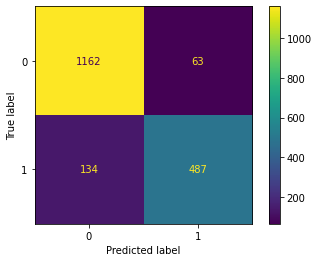

In [27]:
#Chargement du jeu de données JSON
data = load_dataset("dataset_herzig_etal.json")
#Multiplication du titre par un facteur 3 (ajustable)
multiply_title(data,3)
#Extraction du corpus de tickets et des étiquettes 
corpus,labels=get_corpus_labels(data)
#Transformation des étiquettes textuelles en étiquettes binaires
binarized_labels=binarization_labels(labels)
#Création du vectorizer TF-IDF et sélection des k-best features avec feature_computing
vectorizer= TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 3), sublinear_tf=True, stop_words={'english'})
X, vectorizer, ch2 = feature_computing(corpus, binarized_labels, vectorizer,40000)
X_train, X_test, y_train, y_test = train_test_split(X, binarized_labels, test_size=0.33, random_state=42)

#Création du classifieur, entrainement avec X_train, y_train et prédiction avec X_test
clf = SVC(kernel='rbf',probability=True)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)
#affichage de la matrice de confusion ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()


### Explicabilité du classifieur

Un des défis lié à l'IA et aux algorithmes à trait à leur explicabilité. L'explicabilité se définie comme le fait de pouvoir comprendre les mécanismes internes du classifieur qui fondent une ou plusieurs prédictions. Cette explicabilité peut se faire de manière globale (mécanismes internes du classifieur qui conduisent à la classification) ou de manière locale (mécanisme qui conduisent à la classification d'une instance). 

Nous allons expliquer la classification de 4 tickets : 
* 2 tickets sont des faux positifs (indices 3997 et 5098 dans le dataset de tickets)
* 2 tickets sont des faux négatifs (indices 2656 et 3479 dans le dataset de tickets)

Pour expliquer les mots impactant la classification des tickets nous allons utiliser une méthode d'explication se nommant Lime située dans le package Python [eli5](https://eli5.readthedocs.io/en/latest/index.html). 
Pour cela vous pouvez vous inspirer de l'exemple donner dans la documentation de eli5 : [https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#textexplainer](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#textexplainer)

**Attention** avant d'exécuter le code suivant, veillez à avoir exécuté le code du bloc précédent (code de matrice de confusion)

In [28]:
#Pipeline et vectorizer nécessaire pour le TextExplainer
pipe = make_pipeline(vectorizer, ch2, clf)
vectorizer_for_text_explainer = TfidfVectorizer(min_df=1, max_df=1.0,ngram_range=(1, 3), sublinear_tf=True, stop_words={'english'})

#Placez ici le code du text explainer pour le ticket 5098 (ticket_dataset[5098]["title"] + ticket_dataset[5098]["body"])
te = TextExplainer(random_state=42)
te.fit(data[5098]["title"] + data[5098]["body"], pipe.predict_proba)
te.show_prediction()

C:\Users\ibrahim\Desktop\TP-Master-MTP-GL-IA4GL-main\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Placez ci-dessous le code du text explainer pour le ticket 3997 (faux positif)

In [29]:
te.fit(data[3997]["title"] + data[3997]["body"], pipe.predict_proba)
te.show_prediction()

C:\Users\ibrahim\Desktop\TP-Master-MTP-GL-IA4GL-main\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Placez ci-dessous le code du text explainer pour le ticket 2656 (faux négatif)

In [30]:
te.fit(data[2656]["title"] + data[2656]["body"], pipe.predict_proba)
te.show_prediction()

C:\Users\ibrahim\Desktop\TP-Master-MTP-GL-IA4GL-main\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Placez ci-dessous le code du text explainer pour le ticket 3479 (faux négatif)

In [31]:
te.fit(data[3479]["title"] + data[3479]["body"], pipe.predict_proba)
te.show_prediction()

C:\Users\ibrahim\Desktop\TP-Master-MTP-GL-IA4GL-main\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
